In [2]:
import tensorflow as tf

%load_ext autoreload
%autoreload 2

import sys
 
# setting path
sys.path.append('../read_data/')
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt

import cv2

In [3]:
from bbox_utils import match_priors_with_gt, box_overlap_iou, convert_to_centre_dimensions_form

Create a 32 x 32 grid and initialize some ground truth boxes.

The localization loss should only be calculated over ground truth box that where IOU > 0.5 over the default box.

The tensorflow huberloss function averages the loss by the length of the column.

In [6]:
# Assuse we have a 8 x 8 box divided into 2 x 2 prior boxes

image_size = 32
boxes = []
prior_boxes = []
default_box_size  = 4

for i in range(0, image_size // default_box_size,):
    for j in range(0, image_size // default_box_size):
        boxes.append([ j * default_box_size, i * default_box_size, 
                            (j + 1) * default_box_size, (i + 1) * default_box_size ])
        prior_boxes.append( [ j * default_box_size + default_box_size // 2, i * default_box_size + default_box_size // 2, default_box_size, default_box_size ] )
        
gt_boxes = [[6, 10, 12, 20]]
# gt_boxes = [[4, 4, 9, 9], [9, 9, 14 , 14], [24, 24, 29, 29]]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


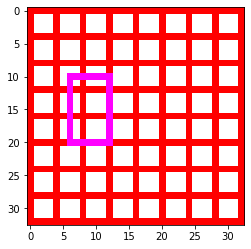

In [7]:
image = np.ones((image_size + 1, image_size + 1, 3))

for box in boxes:
    
    start_x, start_y, end_x, end_y = box
    
    image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], (255, 0 , 0), thickness = 1)

for box in gt_boxes:
    
    start_x, start_y, end_x, end_y = box  
    image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], (255, 0, 255), thickness = 1)

plt.imshow(image)

In [9]:
boxes = np.array(boxes, np.float32) / image_size
prior_boxes = np.array(prior_boxes, np.float32) / image_size


# gt_boxes = [[4, 4, 9, 9], [9, 9, 14 , 14], [24, 24, 29, 29]]
gt_boxes = [[6, 10, 12, 20]]
# gt_labels = [1, 2, 1]
gt_labels = [1]

gt_boxes_normalized = tf.constant([gt_boxes], tf.float32) / image_size

gt_labels = tf.constant([gt_labels])

actual_deltas, actual_labels = match_priors_with_gt(prior_boxes, boxes, gt_boxes_normalized, gt_labels, 3)

In [10]:
-0.015625 / 0.1875

-0.08333333333333333

In [11]:
actual_deltas

<tf.Tensor: shape=(1, 64, 5), dtype=float32, numpy=
array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0

In [12]:
np.random.seed(42)
pred_deltas = np.random.rand(1, 64, 4) * np.random.randint(-1, 2, size = (1, 64, 4))

pred_deltas[0, 9] = [-0.015, 0.012, 0 , -0.031]
pred_deltas[0, 54] = [0.15, 0.12, -0.0123 , -0.04]

huber_loss = tf.keras.losses.Huber(
    reduction=tf.keras.losses.Reduction.NONE
)

huber_loss([ [-0.015625, -0.015625, -0.03125 , -0.03125], [0.15, 0.12, -0.0123 , -0.04] ], 
           [ [-0.015, 0.012, 0 , -0.031], [-0.015625, -0.015625, -0.03125 , -0.03125]])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.00021752, 0.00578268], dtype=float32)>

In [13]:
from classification_loss import SSDLoss

In [14]:
loss = SSDLoss()

loss.localization_loss(actual_deltas, pred_deltas)

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>